In [50]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [38]:
#Read NO-NO2-NOx Series
dataFrame = pd.read_excel("../data/DataAirTrain.xlsx",index_col= 'time', sheet_name="NO-NO2-NOx")
dataFrame = dataFrame.tail(1000)

In [39]:
dataFrame[['NO','NOx']] = dataFrame[['NO','NOx']].interpolate(method='linear')

In [40]:
#Using linear regression to fill missing data
linearModel = LinearRegression()
dataFrame = dataFrame.copy()
nanMask = dataFrame[['NO2']].isna()
nanMask = nanMask['NO2']

xTrain = dataFrame.loc[~nanMask,['NOx']]
yTrain = dataFrame.loc[~nanMask,['NO2']]

linearModel.fit(xTrain, yTrain)

xTest = dataFrame.loc[nanMask, ['NOx']]
yTest = linearModel.predict(xTest)
dataFrame.loc[nanMask,['NO2']] = yTest

In [41]:
#Fix gap in time index
dataFrame = dataFrame.resample('H').interpolate(method='linear')

In [42]:
from statsmodels.tsa.stattools import adfuller
def stationary(var, desc):
    print(
        f"'{desc}' is stationary: "
        f"{adfuller(var)[0] < adfuller(var)[4]['1%']}.")
stationary(dataFrame.NO, 'NO')
stationary(dataFrame.NO2, 'NO2')
stationary(dataFrame.NOx, 'NOx')

'NO' is stationary: True.
'NO2' is stationary: False.
'NOx' is stationary: False.


In [43]:
trainSet = dataFrame[: -48]
testSet = dataFrame[-48: ]
dataFrameCopy = dataFrame
dataFrame = trainSet

In [44]:
from statsmodels.tsa.api import VAR
model = VAR(dataFrame)

In [45]:
sorted_order = model.select_order(72)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        12.10       12.12   1.805e+05       12.11
1        8.236       8.300       3773.       8.260
2        7.847       7.960       2558.       7.890
3        7.705      7.867*       2221.       7.767
4        7.685       7.895       2176.       7.765
5        7.657       7.915       2116.      7.756*
6        7.647       7.953       2094.       7.764
7        7.632       7.987       2063.       7.767
8        7.645       8.048       2090.       7.799
9        7.636       8.087       2071.       7.808
10       7.640       8.140       2080.       7.831
11       7.646       8.195       2093.       7.856
12       7.656       8.253       2115.       7.884
13       7.665       8.310       2134.       7.912
14       7.677       8.370       2159.       7.942
15       7.679       8.420       2163.       7.962
16       7.689       8.479     

In [46]:
lag = sorted_order.aic
results = model.fit(lag)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Mar, 2023
Time:                     00:39:48
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    9.01739
Nobs:                     933.000    HQIC:                   8.11267
Log likelihood:          -7214.01    FPE:                    1914.17
AIC:                      7.55498    Det(Omega_mle):         1435.21
--------------------------------------------------------------------
Results for equation NO
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.249201         0.402150            0.620           0.535
L1.NO           0.023168         0.153184            0.151           0.880
L1.NO2         -0.501940         0.080444           -6.240           0.000
L1.NOx      

                           NO        NO2       NOx
time                                              
2019-09-03 07:00:00  3.006433   7.937595  3.215671
2019-09-03 08:00:00  3.865802   8.131727  5.387704
2019-09-03 09:00:00  3.152411   8.143996  4.824658
2019-09-03 10:00:00  3.222996   7.530141  4.120728
2019-09-03 11:00:00  7.651377   6.720880  7.547733
2019-09-03 12:00:00  5.838393   6.697981  3.489191
2019-09-03 13:00:00  2.761723   3.744053 -1.585682
2019-09-03 14:00:00  3.083574   3.299020 -2.369506
2019-09-03 15:00:00  4.260274   3.344962 -2.066565
2019-09-03 16:00:00  2.979953   2.742606 -3.625971
2019-09-03 17:00:00  2.198926   5.104793 -2.602654
2019-09-03 18:00:00  1.729491   6.572305 -1.996256
2019-09-03 19:00:00  1.746255   7.787664 -0.809942
2019-09-03 20:00:00  2.304752  10.033939  1.231835
2019-09-03 21:00:00  1.550685  10.940050  0.977709
2019-09-03 22:00:00  0.572352  10.011550 -1.125455
2019-09-03 23:00:00  3.231437   9.730113  1.032220
2019-09-04 00:00:00  5.429313  

<AxesSubplot:title={'center':'Test Set'}, xlabel='time'>

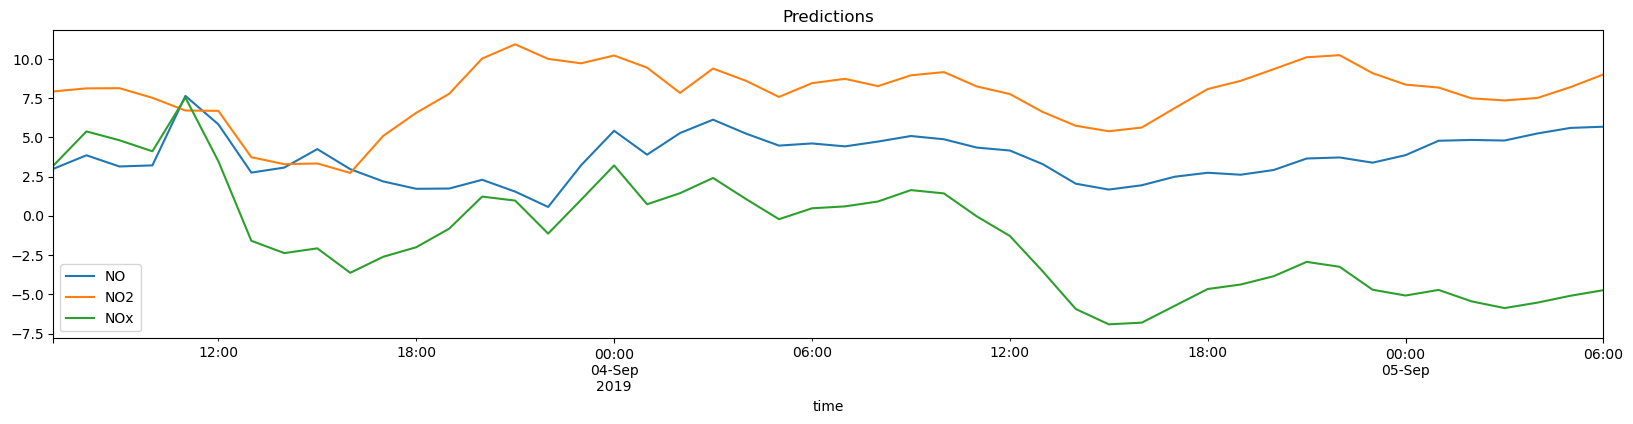

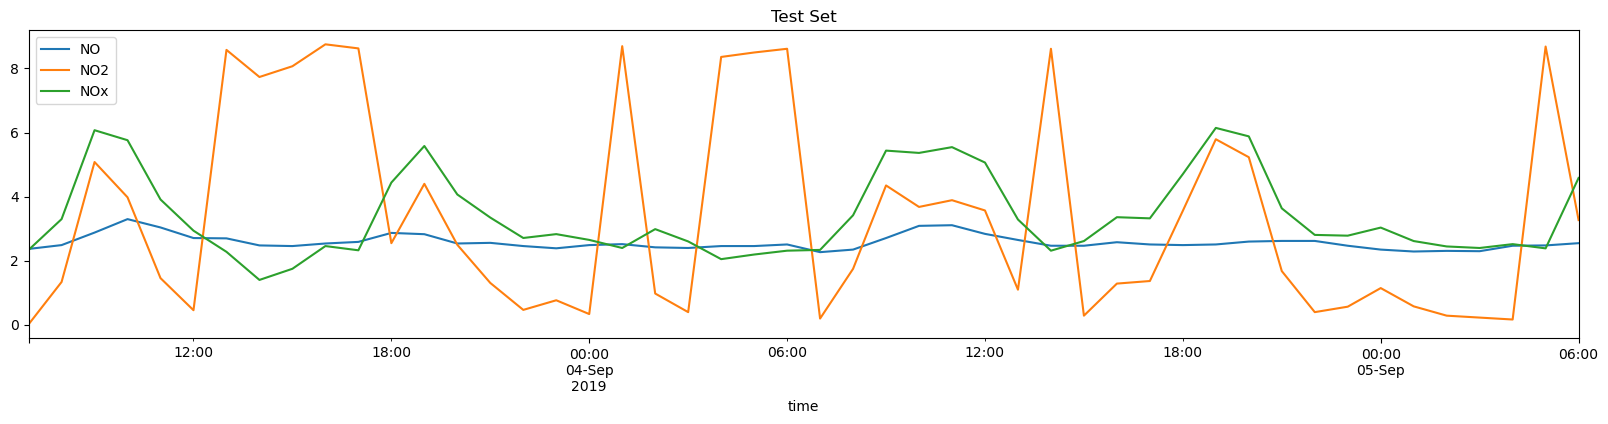

In [53]:
step = 48
dateTimeIndex = pd.date_range(dataFrame.index[-1] + pd.DateOffset(hours=1), periods=step, freq="H")
predictions = results.forecast(dataFrame.values[-lag :], steps = step)
dataFramePredicted = pd.DataFrame({'time':dateTimeIndex, 'NO':predictions[:,0], 'NO2':predictions[:,1], 'NOx':predictions[:,2]})
dataFramePredicted = dataFramePredicted.set_index('time')
print(dataFramePredicted)
dataFramePredicted.plot(figsize=(20,4), title='Predictions')
testSet.plot(figsize=(20,4), title='Test Set')


In [48]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})
tmp = []
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,0], testSet.iloc[:,0]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,1], testSet.iloc[:,1]))
tmp.append(forecast_accuracy(dataFramePredicted.iloc[:,2], testSet.iloc[:,2]))
metric = pd.DataFrame(tmp,index=dataFramePredicted.columns.values)
print(metric)

          mape        me       mae        mpe      rmse      corr    minmax
NO    0.601887  1.204634  1.524025   0.479249  1.885101 -0.002397  0.345979
NO2  16.145836  4.365492  5.527916  16.007207  6.108557 -0.415597  0.664194
NOx   1.590948 -4.661439  4.982992  -1.493548  5.853893  0.183923  1.572989


C:\Users\admin\AppData\Local\Temp\ipykernel_8064\3187061451.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_8064\3187061451.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\admin\AppData\Local\Temp\ipykernel_8064\3187061451.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
C:\Users\admin\AppData\Local\Temp\ipykernel_8064\3187061451.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:,